# Time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random as rd

# time series modules
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

### Dataset info
1. sales
: date, date_block_num, shop_id, item_id, item_price, item_cnt_day

2. item_cat
: item_category_name, item_category_id

3. item
: item_name, item_id, item_category_id

4. shops
: shop_name, shop_id


### Variables
 + ID - an Id that represents a (Shop, Item) tuple within the test set
 + shop_id - unique identifier of a shop
 + item_id - unique identifier of a product
 + item_category_id - unique identifier of item category
 + item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
 + item_price - current price of an item
 + date - date in format dd/mm/yyyy
 + date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 + item_name - name of item
 + shop_name - name of shop
 + item_category_name - name of item category

In [2]:
sales = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

print(sales.shape)
print(item_cat.shape)
print(item.shape)
print(shops.shape)
print(test.shape)

(2935849, 6)
(84, 2)
(22170, 3)
(60, 2)
(214200, 3)


In [3]:
sales['date'] = sales['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [4]:
print(min(sales['date']))
print(max(sales['date']))

2013-01-01 00:00:00
2015-10-31 00:00:00


In [5]:
# aggregation to monthly level
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['date', 'item_price', 'item_cnt_day'].agg({'date': ['min', 'max'], 'item_price': 'mean', 'item_cnt_day': 'sum'})
monthly_sales.head(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

## 1. Single time series
 + Data only contains time and single response.
  - time: date_block_num
  - response: daily sales of items

### (1) 일별 Trend 

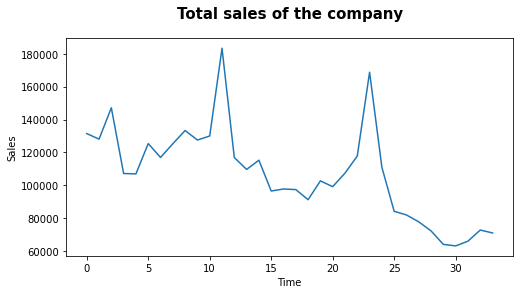

In [6]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')

plt.figure(figsize = (8, 4))
plt.title('Total sales of the company', fontsize = 15, fontweight = 'bold', pad = 20)
plt.xlabel('Time'); plt.ylabel('Sales')
plt.plot(ts)
plt.show()

### (2) 이동평균 Trend

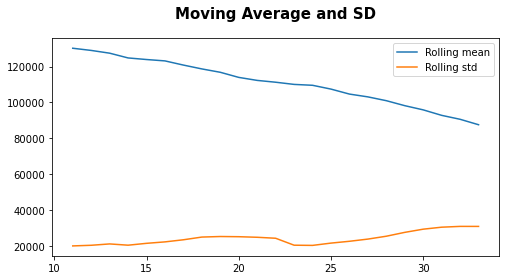

In [7]:
plt.figure(figsize = (8, 4))
plt.plot(ts.rolling(window = 12, center = False).mean(), label = 'Rolling mean')
plt.plot(ts.rolling(window = 12, center = False).std(), label = 'Rolling std')
plt.title("Moving Average and SD", fontsize = 15, fontweight = 'bold', pad = 20)
plt.legend()
plt.show()

**계절성(Seasonality)** 와 **일별 item sales의 감소 추세** 확인 가능

#### Multiplicative model
$ \hat{y(t)} = Level * Trend * Seasonality * Noise $

 + 시간에 따른 변화폭이 커지거나 작아진다
 + Trend: 비선형적인 상승 및 하락 추세
 + Seasonality: frequency와 amplitude가 커지거나 작아짐

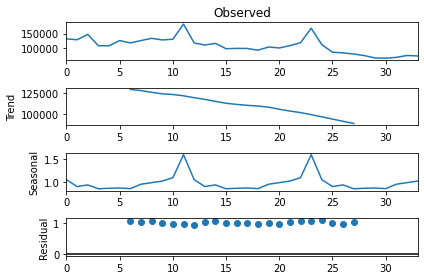

In [8]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts.values, freq = 12, model = 'multiplicative')
fig = res.plot()

#### Additive model
$ \hat{y(t)} = Level + Trend + Seasonality + Noise $

 + 시간에 따른 변화가 일정
 + Trend: 선형적인 상승 및 하락 추세
 + Seasonality: frequency와 amplitude가 일정

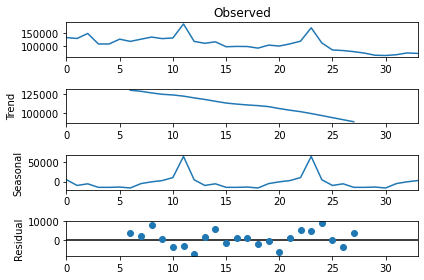

In [9]:
res = sm.tsa.seasonal_decompose(ts.values, freq = 12, model = 'additive')
fig = res.plot()

### Stationary (정상성)
![stationary](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

#### 정상성검정 (ADF Test)
 + $ H_{0}$: 단위근을 가짐(비정상성)
 + $ H_{1}$: 정상성
 
<br>

차분 전 시계열데이터는 비정상성(non-stationary)

In [10]:
# stationary test
def test_stationarity(timeseries):
    print('Results of Dicky-Fuller Test')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
test_stationarity(ts)

Results of Dicky-Fuller Test
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of observations used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [11]:
from pandas import Series as Series

# 1차 차분
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

[]

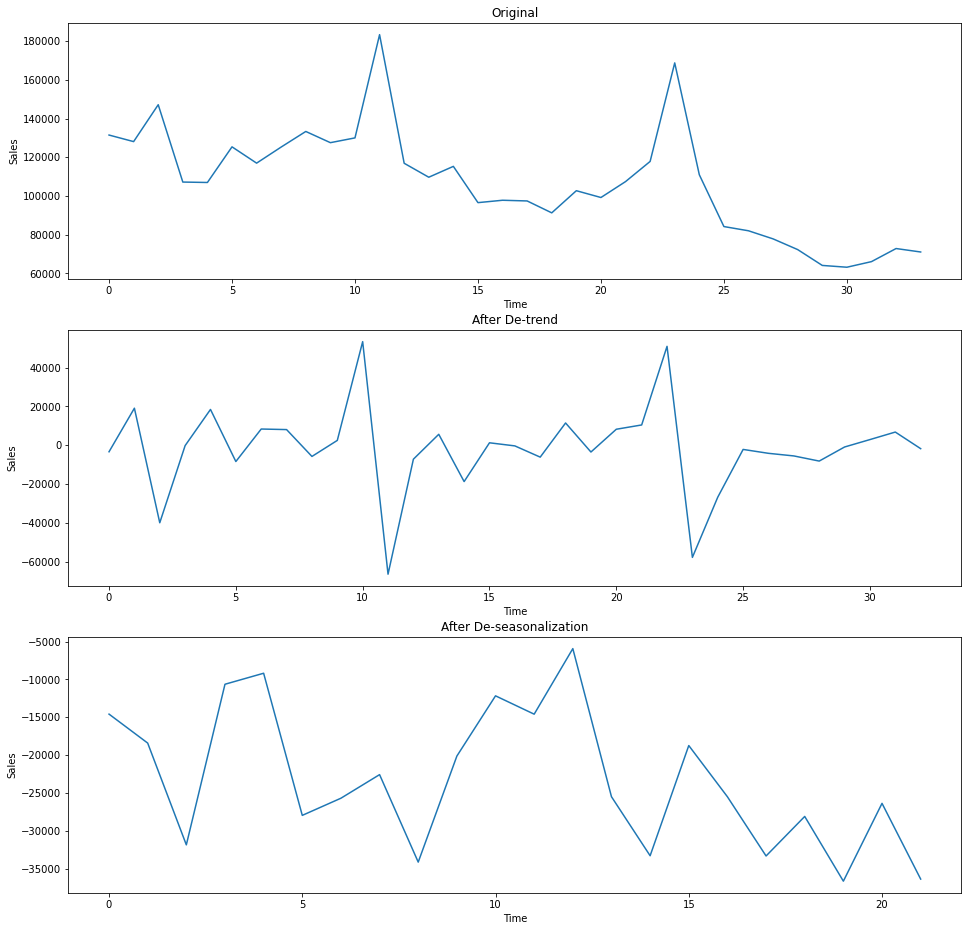

In [12]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [13]:
# 1차 차분 후 정상성 검정
test_stationarity(new_ts)

Results of Dicky-Fuller Test
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of observations used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


## 2. AR, MA, ARMA
 + AR(autogregressive): 시점 t의 값 $Z_{t}$를 과거시점의 값들을 이용한 회귀식으로 표현
 + MA(moving average): 시점 t의 값 $Z_{t}$를 현재와 과거시점의 백색잡음으로 표현

In [18]:
def tsplot(y, lags = None, figsize = (10, 8), title = '', style = 'bmh'):
    if not isinstance(y, pd.Series): # y가 Series형인지 알아봄
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.5)
        sm.qqplot(y, line = 's', ax = qq_ax)
        qq_ax.set_title('QQ plot')
        scs.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)
        plt.tight_layout()
        
        return

### AR(1)
$Z_{t} = \phi_{1}Z_{t-1}+a_{t}$

 + $a_{t}$: 백색잡음 혹은 오차항
 + 정상성을 위해 $-1 < \phi_{1} < 1$ 조건 필요

#### 그래프 해석
 1. PACF: 시차 1 이후로 절단된 패턴
 2. ACF: 지수적으로 감소하는 패턴

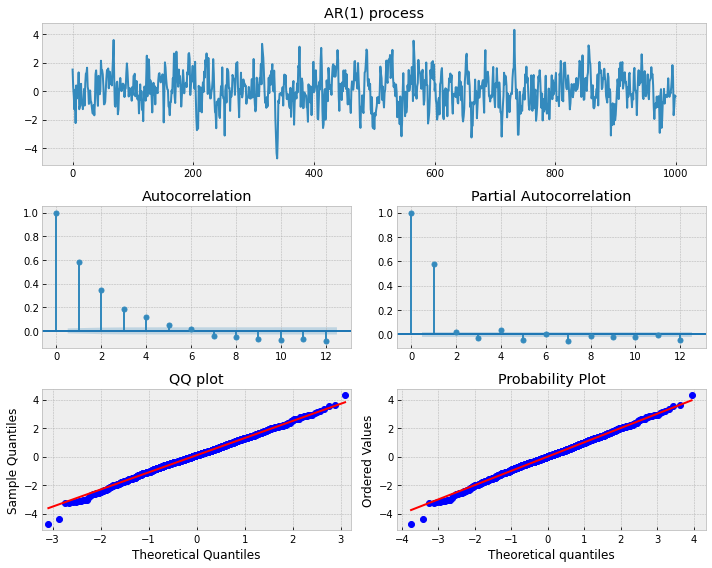

In [19]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size = n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t] 
limit = 12
_ = tsplot(x, lags = limit, title = 'AR(1) process')

### MA(1)
$ Z_{t} = a_{t} + \theta_{1}a_{t-1} $
 + $a_{t}$: 백색잡음 혹은 오차항
 + 시점 t의 값은 시점 t와 시점 t-1의 오차항으로 생성된다
 + $ -1<\theta_{1}<1$ 조건 필요

#### 그래프 해석
 1. PACF: 지수적으로 감소하는 패턴
 2. ACF: 시차 1 이후로 절단된 패턴

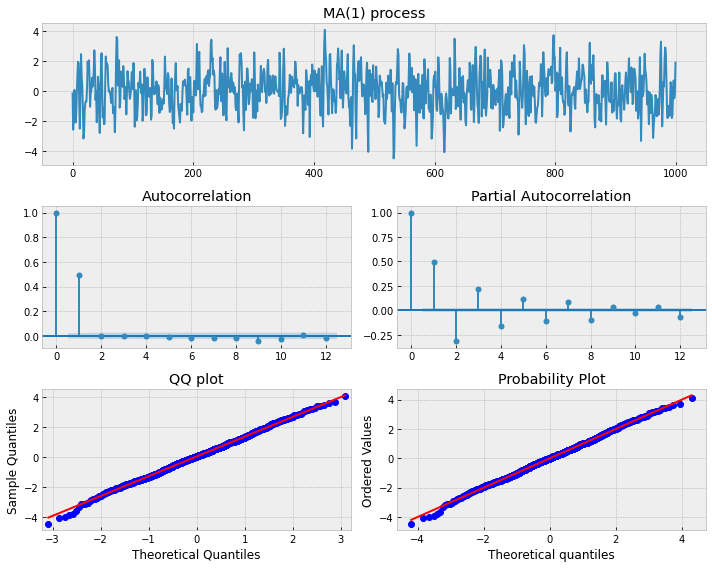

In [20]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.8])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
limit = 12

_ = tsplot(ma1, lags = limit, title = "MA(1) process")

### Sales data의 적절한 차분 수 구하기

In [21]:
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order = (i, j)).fit(method = 'mle', trend = 'nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except:
            continue
            
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)
